# OTE-01: Initial Image Mosaic

Steps:
- Perturb the primary and secondary mirrors to reflect expectations for initial deployment
- Record the tilt of each PM and remove the piston/tip/tilt
- Generate segment PSFs
- ... figure out how to turn those PSFS into MIRAGE simulations

> Email from Marshall:
- Create 18 independent segment PSFs centered on each segment, each with some suitably small size rather than gigantic: 
    - Apply random perturbations as you are doing. 
    - For each segment, cut out just that segment from the OPD map (using the one_segment_pupil helper function in WebbPSF).
    - This part’s somewhat tricky. For each segment we will want to record what the tip/tilt  is, then zero it out before creating the PSF (so that we get the PSF centered on where the segment is). We can use the tip/tilt values in the OPD to compute the equivalent vector to where that PSF would be. 
    - End result should be 18 separate PSF arrays, plus for each one a tip/tilt vector saying where that should appear relative to the center of the PSF array.
- Iterate over the list of targets in MIRAGE
- For each target, iterate over the list of 18 PSFs and their offsets. 
- Compute the apparent location of that PSF as the sum of the coordinates that star would normally have in the field of view plus the offset to that PSF.
- If that PSF falls inside the detector field of view somewhere, put it there. Otherwise, skip that PSF. 

In [2]:
# Standard Library Imports
from glob import glob
import multiprocessing
import os
import re
import sys
import time
import yaml

# Third Party Imports
from astropy.io import ascii as asc
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import pprint
import pysiaf
import webbpsf

# Local Imports
from mirage import imaging_simulator
from mirage.apt import apt_inputs
from mirage.catalogs import get_catalog
from mirage.dark import dark_prep
from mirage.psf import psf_library, psf_selection, deployments
from mirage.ramp_generator import obs_generator
from mirage.seed_image import catalog_seed_image
from mirage.yaml import yaml_generator
# from mirage.yaml import write_observationlist

# View matplotlib plots inline
%matplotlib inline

### Define location of input and output files

In [4]:
# Where the pointing and XML file for this particular OTE CAR are located
ote_dir = '/Users/lchambers/TEL/mirage/OTECommissioning/OTE01_reducedmosaic/'

# Where the input PSF FITs files will be saved to
library_root_dir = '/user/lchambers/OTECommSims/test_OTE01_library/'

In [ ]:
# # TO SIMULATE LARGE TILTS

# # Where the pointing and XML file for this particular OTE CAR are located
# ote_dir = '/Users/lchambers/TEL/mirage/OTECommissioning/OTE01_largetilts/'

# # Where the input PSF FITs files will be saved to
# library_root_dir = '/user/lchambers/OTECommSims/OTE01_library_largetilt/'

In [5]:
prop_id = 1134

# Change if you named your files differently.
root = 'OTE01-{}-reduced_mosaic'.format(prop_id)

pointing_file = os.path.join(ote_dir, '{}.pointing'.format(root))
xml_file = os.path.join(ote_dir, '{}.xml'.format(root))

---
# First, simulate the OTE state

### Option 1: Load OTE state from YAML file

In [67]:
deployments_file = '/Users/lchambers/TEL/mirage/OTECommissioning/OTE01_reducedmosaic/' + \
                   'deployment_errors_20181219_100044.yaml'
ote, segment_tilts, ote_opd_with_tilts = deployments.load_ote_from_deployment_yaml(deployments_file, ote_dir)

Saved OPD to /Users/lchambers/TEL/mirage/OTECommissioning/OTE01_reducedmosaic/OPD_withtilt_20190521_172723.fits
Saved OPD with piston/tip/tilt removed to /Users/lchambers/TEL/mirage/OTECommissioning/OTE01_reducedmosaic/OPD_notilt_20190521_172723.fits


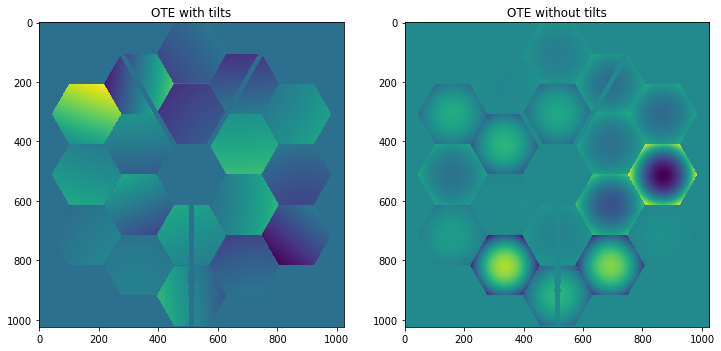

Segment poses in Control coordinates: (microns for decenter & piston, microradians for tilts and clocking):
  	      Xtilt      Ytilt     Piston   Clocking     Radial        ROC
A1	     0.0000     0.0000     0.0000   -69.2838   -11.6081     1.2340
A2	     0.0000     0.0000     0.0000   -30.8904    66.6507     6.9483
A3	     0.0000     0.0000     0.0000    10.8656   -28.6604     3.3583
A4	     0.0000     0.0000     0.0000    -8.0277    49.7982    -3.4294
A5	     0.0000     0.0000     0.0000   -59.7755    28.9149    -5.4721
A6	     0.0000     0.0000     0.0000  -122.2431   -49.3817    -0.1381
B1	     0.0000     0.0000     0.0000   -21.6855    11.9638    -5.2000
C1	     0.0000     0.0000     0.0000    41.2870   -81.3350    -9.7073
B2	     0.0000     0.0000     0.0000    26.9592   -58.3405    -0.4987
C2	     0.0000     0.0000     0.0000   -65.5049     9.8835    14.4599
B3	     0.0000     0.0000     0.0000    10.8868   106.7843     3.9275
C3	     0.0000     0.0000     0.0000    85.1403    1

In [57]:
# Display OTE state and tip/tilt vectors
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(ote_opd_with_tilts)
ax1.set_title('OTE with tilts')
ax2.imshow(ote.opd)
ax2.set_title('OTE without tilts')
plt.show()

ote.print_state()

print()
header_string = 'Segment Number |{:^11}|{:^11}'.format('X Tilt', 'Y Tilt')
print(header_string)
print('-' * len(header_string))
for i, (x, y) in enumerate(segment_tilts):
    i_segment = i + 1
    segname = webbpsf.webbpsf_core.segname(i_segment)
    print('{:^14} | {:9.6} | {:9.6}'.format(segname, x, y))

### Option 2: Randomly generate new OTE state

In [72]:
ote, segment_tilts, ote_opd_with_tilts = deployments.generate_random_ote_deployment(
    ote_dir, reduction_factor=0.2
)

Saved deployment errors to /Users/lchambers/TEL/mirage/OTECommissioning/OTE01_reducedmosaic/deployment_errors_20190521_173912.yaml
Saved reduced (20.0%) deployment errors to /Users/lchambers/TEL/mirage/OTECommissioning/OTE01_reducedmosaic/deployment_errors_reduced_20190521_173912.yaml
Saved OPD to /Users/lchambers/TEL/mirage/OTECommissioning/OTE01_reducedmosaic/OPD_withtilt_20190521_173924.fits
Saved OPD with piston/tip/tilt removed to /Users/lchambers/TEL/mirage/OTECommissioning/OTE01_reducedmosaic/OPD_notilt_20190521_173925.fits


(<webbpsf.opds.OTE_Linear_Model_WSS at 0x1c2945f4e0>,
 array([[  7.10006473,   2.21016087],
        [ 17.85673777,  -6.31227651],
        [ 27.02872241,  75.70412222],
        [119.31345178,  65.64938812],
        [-10.19816647,  42.48939102],
        [ -0.84538615,  -8.8120464 ],
        [107.29459629,  -4.36493751],
        [-50.7584335 ,  16.00515899],
        [ -0.20779595, -59.08308773],
        [ 19.45176575,  57.77244303],
        [ -1.69734899,  38.04584567],
        [  5.97757253, -25.58136989],
        [ 14.28421744,  66.04868174],
        [ 21.97157023, -14.89018761],
        [  2.08378816, -64.53292406],
        [ 29.49622994,  60.48878897],
        [ 55.43197608,  93.62705051],
        [ 53.22953882,  40.36709799],
        [ 16.2661078 , -96.72482537]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0

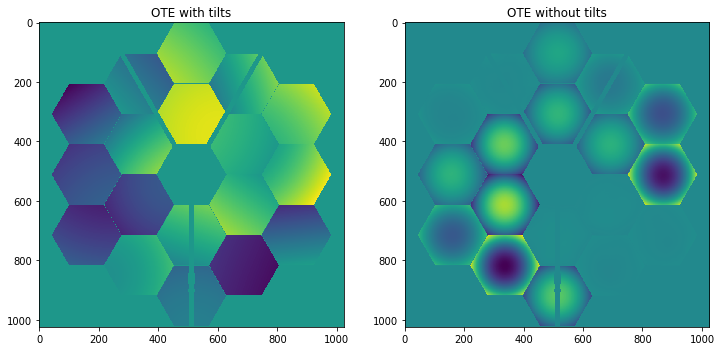

Segment poses in Control coordinates: (microns for decenter & piston, microradians for tilts and clocking):
  	      Xtilt      Ytilt     Piston   Clocking     Radial        ROC
A1	     0.0000     0.0000     0.0000   -62.8274    37.0337    -0.3709
A2	     0.0000     0.0000     0.0000    -5.6095     3.3435    -0.3352
A3	     0.0000     0.0000     0.0000    27.3455    46.0950    -5.2228
A4	     0.0000     0.0000     0.0000   -14.4698    32.4066    -5.7987
A5	     0.0000     0.0000     0.0000   -49.0125   -20.0693    -9.7647
A6	     0.0000     0.0000     0.0000   -27.5677    33.6795   -12.4555
B1	     0.0000     0.0000     0.0000   -25.2485    20.0429    -8.5069
C1	     0.0000     0.0000     0.0000    29.7560   -35.8164     0.3532
B2	     0.0000     0.0000     0.0000     3.4195     7.9249     0.2909
C2	     0.0000     0.0000     0.0000     9.8066   -18.0392    13.3887
B3	     0.0000     0.0000     0.0000    30.8560   -17.1583     7.1339
C3	     0.0000     0.0000     0.0000   -17.0190    1

In [61]:
# Display OTE state and tip/tilt vectors
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(ote_with_tilts_opd)
ax1.set_title('OTE with tilts')
ax2.imshow(ote.opd)
ax2.set_title('OTE without tilts')
plt.show()

ote.print_state()

print()
header_string = 'Segment Number |{:^11}|{:^11}'.format('X Tilt', 'Y Tilt')
print(header_string)
print('-' * len(header_string))
for i, (x, y) in enumerate(segment_tilts):
    i_segment = i + 1
    segname = webbpsf.webbpsf_core.segname(i_segment)
    print('{:^14} | {:9.6} | {:9.6}'.format(segname, x, y))

---
# Second, generate PSF library files

In [88]:
psf_library.generate_segment_psfs(ote, segment_tilts, library_root_dir, 
                                  filters='F212N', detectors='NRCA3', overwrite=True)

GENERATING SEGMENT A1-1 DATA
------------------------------

Starting filter: F212N
  Running detector: NRCA3
  Saving file: /user/lchambers/OTECommSims/test_OTE01_library/nircam_f212n_fovp1024_samp1_npsf1.fits
Completed segment 1
Elapsed time: 18.055460929870605

GENERATING SEGMENT A2-2 DATA
------------------------------

Starting filter: F212N
  Running detector: NRCA3
  Saving file: /user/lchambers/OTECommSims/test_OTE01_library/nircam_f212n_fovp1024_samp1_npsf1.fits
Completed segment 2
Elapsed time: 17.70099139213562

GENERATING SEGMENT A3-3 DATA
------------------------------

Starting filter: F212N
  Running detector: NRCA3
  Saving file: /user/lchambers/OTECommSims/test_OTE01_library/nircam_f212n_fovp1024_samp1_npsf1.fits
Completed segment 3
Elapsed time: 16.782891035079956

GENERATING SEGMENT A4-4 DATA
------------------------------

Starting filter: F212N
  Running detector: NRCA3
  Saving file: /user/lchambers/OTECommSims/test_OTE01_library/nircam_f212n_fovp1024_samp1_npsf1.

In [134]:
from webbpsf.utils import to_griddedpsfmodel

---
# Third, create `.yaml` files for each exposure

### Get the source catalogs

In [73]:
# Get SW and LW catalogs
cats = get_catalog.get_all_catalogs(pointing_file, prop_id)
target_coords, catalog_filenames_sw, catalog_filenames_lw = cats

cat_dict = {'nircam': {'lw': catalog_filenames_lw,
                       'sw': catalog_filenames_sw}}

Target coordinates:  146.87731 63.24781
Shortwave catalog file 2MASS_RA146.88deg_Dec63.25deg.list already exists. Will not overwrite.
Longwave catalog file WISE_RA146.88deg_Dec63.25deg.list already exists. Will not overwrite.


In [149]:
# Create a series of data simulator input yaml files from APT files
yaml_dir = os.path.join(ote_dir, 'yamls')
yam = yaml_generator.SimInput(input_xml=xml_file, pointing_file=pointing_file,
                              catalogs=cat_dict,
                              verbose=True, output_dir=yaml_dir, simdata_output_dir=ote_dir)

# Define the paths to the PSF libraries, and specify to use segment PSFs
yam.psf_paths = os.path.expandvars(library_root_dir)
yam.expand_catalog_for_segments = True
yam.add_psf_wings = False

# Create yaml files
# (Within this, create the observation table.)
yam.create_inputs()

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Observation `001` labelled `Central` uses template `NircamImaging`
APTObservationParams Dictionary holds 0 entries before reading template
Primary dither element PrimaryDithers not found, use default primary dithers value (1).
Number of dithers: 1 primary * 1 subpixel = 1
Dictionary read from template has 1 entries.
Found 6 tile(s) for observation 001 Central
Found 2 visits with numbers: [1, 2]
APTObservationParams Dictionary holds 6 entries after reading template (+6 entries)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Observation `002` labelled `W` uses template `NircamImaging`
APTObservationParams Dictionary holds 6 entries before reading template
Primary dither element PrimaryDithers not found, use default primary dithers value (1).
Number of dithers: 1 primary * 1 subpixel = 1
Dictionary read from template has 1 entries.
Foun

In [82]:
# Print information about the yaml files that were generated.
yfiles = glob(os.path.join(yaml_dir, 'jw*yaml'))

visit_numbers = [f.split('/')[-1].split('_')[0] for f in yfiles]
all_visit_numbers = list(set(visit_numbers))
all_visit_numbers.sort()

n_obs = len(set([int(number[9:11]) for number in all_visit_numbers]))

print('Found {} yaml files.'.format(len(yfiles)))
print('({} visits across {} observations)'.format(len(all_visit_numbers), n_obs))

Found 2640 yaml files.
(90 visits across 7 observations)


---
# 3.5th, examine where the sources will fall in an example exposure

### Examine target pointings relative to apertures and V2/V3 references

Example files for each pointing:
--------------------------------
1. jw01134001001_01104_00001_nrca2.yaml
2. jw01134001001_01101_00001_nrcb2.yaml
4. jw01134001002_01105_00001_nrca3.yaml
5. jw01134001002_01106_00001_nrcb5.yaml
6. jw01134001001_01103_00001_nrca2.yaml
25. jw01134001001_01102_00001_nrca3.yaml


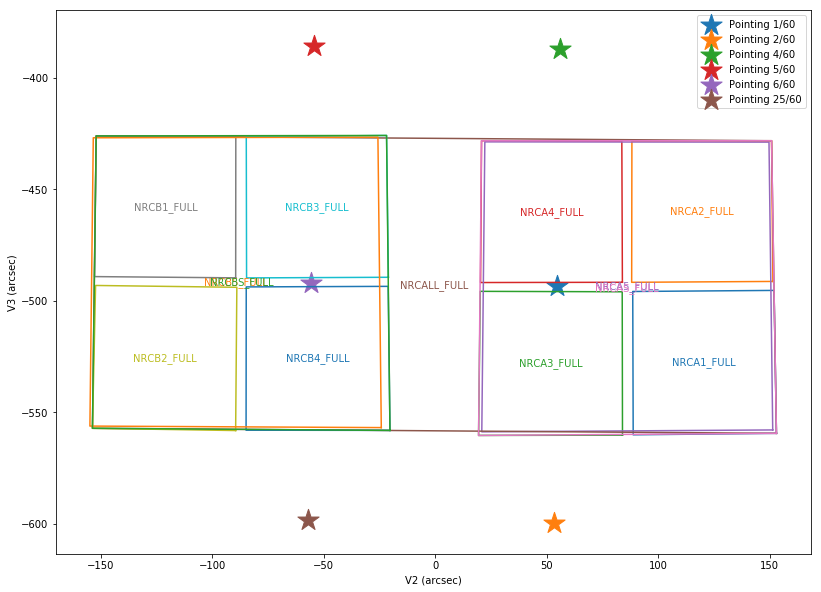

In [83]:
nc_siaf = pysiaf.Siaf('NIRCam')
nc_full = nc_siaf['NRCA3_FULL']

plt.figure(figsize=(15,10))
for apername in sorted(nc_siaf.apernames):
    a = apername
    if ('_FULL' in a) and ('OSS' not in a) and ('MASK' not in a) and (a[-1] != 'P'):
        nc_siaf[a].plot(frame='tel', name_label=a, fill_color='white')
plt.gca().invert_xaxis()

# Compare V2/V3 of targets (from .pointing file)
all_pointings = set([(v2, v3, filename) for v2, v3, filename in zip(yam.info['v2'], 
                                                                yam.info['v3'], 
                                                                yam.info['yamlfile']) if 'jw01134001' in filename])

print('Example files for each pointing:')
print('--------------------------------')
plotted_points = []
for i_point, (v2, v3, filename) in enumerate(all_pointings):
    if (v2, v3) not in plotted_points:
        plotted_points.append((v2, v3))
        plt.scatter(v2, v3, marker='*', s=500, 
                    label='Pointing {}/{}'.format(i_point + 1, len(all_pointings)))
        print('{}. {}'.format(i_point + 1, filename))

plt.legend()

plt.show()

In [100]:
# Save the yam.info dictionary to a yaml file that can be opened
with open('OTE-10-yam.info.yaml', 'w') as outfile:
    yaml.dump(yam.info, outfile, default_flow_style=False)

### Select the YAML to generate an image from

In [84]:
# Select one YAML to estimate where the sources will be
test_yaml_filename = 'jw01134001002_01106_00001_nrca3.yaml'
test_yaml = os.path.join(yaml_dir, test_yaml_filename)
print(test_yaml)
yaml_ind = np.where(np.array(yam.info['yamlfile']) == test_yaml_filename)[0][0]

/Users/lchambers/TEL/mirage/OTECommissioning/OTE01_reducedmosaic/yamls/jw01134001002_01106_00001_nrca3.yaml


### Calculate and plot V2/V3 locations of NRCA3 aperture, target, and sources

In [130]:
# Examine apertures and V2/V3 references for each array/subarray
nc_siaf = pysiaf.Siaf('NIRCam')
nc_a3 = nc_siaf['NRCA3_FULL']
nc_all = nc_siaf['NRCALL_FULL']

# Get the target RA/Dec
target_ra = float(yam.info['ra'][yaml_ind])
target_dec = float(yam.info['dec'][yaml_ind])
print('Target RA/Dec:', target_ra, target_dec)

# Get the aperture pointing - THIS IS FOR NRCALL_FULL
pointing_v2 = yam.info['v2'][yaml_ind]
pointing_v3 = yam.info['v3'][yaml_ind]

# Get the aperture RA/Dec - THIS IS FOR NRCA3_FULL
pointing_ra = float(yam.info['ra_ref'][yaml_ind])
pointing_dec = float(yam.info['dec_ref'][yaml_ind])
print('NRCA3 Pointing RA/Dec:', pointing_ra, pointing_dec)

# Generate the attitude matrix to convert RA/Dec to V2/V3
position_angle = float(yam.info['PAV3'][yaml_ind])
attitude_ref = pysiaf.utils.rotations.attitude(
    pointing_v2, pointing_v3, target_ra, target_dec, position_angle
)

# Get the V2/V3 positions of all sources
sw_catalog_file = yam.info['sw_ptsrc'][yaml_ind]
sw_catalog = asc.read(sw_catalog_file)
v2, v3 = pysiaf.utils.rotations.getv2v3(attitude_ref, sw_catalog['x_or_RA'], sw_catalog['y_or_Dec'])

# Get the V2/V3 position of the target (the same as the NRCALL pointing)
target_v2, target_v3 = pysiaf.utils.rotations.getv2v3(attitude_ref, target_ra, target_dec)

# Get the V2/V3 position of the aperture pointing
a3_v2, a3_v3 = pysiaf.utils.rotations.getv2v3(attitude_ref, pointing_ra, pointing_dec)

Target RA/Dec: 146.87731 63.24781
NRCA3 Pointing RA/Dec: 146.77196760996176 63.23422083399082


In [116]:
# Get offsets for each segment
library_list = psf_selection.get_segment_library_list('NIRCam', 'NRCA3', 'F212N', library_root_dir)

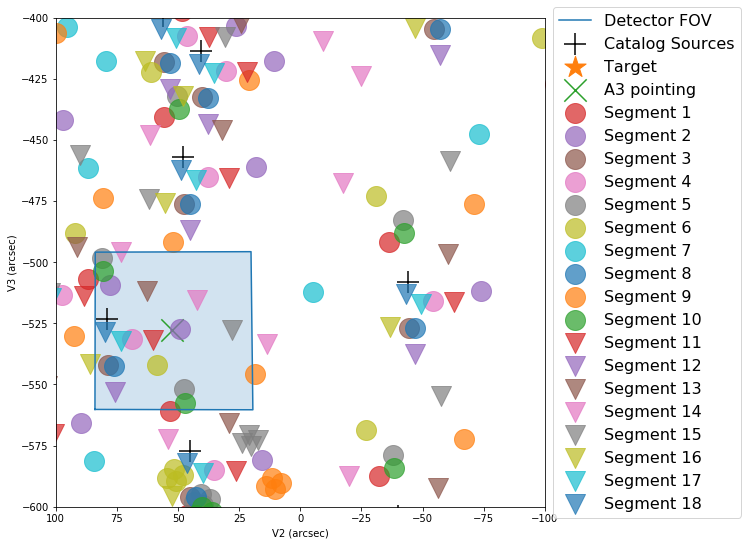

In [120]:
# Plot V2/V3 locations of aperture, target, and sources

fig, ax = plt.subplots(1, 1, figsize=(15,10))
nc_a3.plot(frame='tel', fill_color=None, label='Detector FOV', fill_alpha=0.2)

# Plot catalog sources
plt.scatter(v2, v3, label='Catalog Sources', marker='+', s=500, c='black')

# Plot the target (the same as the NRCALL pointing)
plt.scatter(target_v2, target_v3, label='Target', marker='*', s=500)

# Plot the center of aperture pointing
plt.scatter(a3_v2, a3_v3, label='A3 pointing', marker='x', s=500)

# Plot segment sources
for i_segment in np.arange(1, 19):
    marker = 'o'
    if i_segment > 10:
        marker = 'v'
    x_arcsec, y_arcsec = psf_selection.get_segment_offset(i_segment, 'NRCA3', library_list)
    plt.scatter(v2 - x_arcsec, v3 + y_arcsec, 
                label='Segment {}'.format(i_segment), marker=marker, s=400, alpha=0.7)

# Just show the area close to the detector
plt.xlim(100, -100)
plt.ylim(-600, -400)

# Shrink current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width * 0.9, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=16, facecolor=None)

plt.show()

---
# Fourth, actually generate images

In [132]:
test_yaml

'/Users/lchambers/TEL/mirage/OTECommissioning/OTE01_reducedmosaic/yamls/jw01134001002_01106_00001_nrca3.yaml'

In [157]:
test_yaml = os.path.join(yaml_dir, 'jw01134001002_01106_00001_nrca3.yaml')
cat = catalog_seed_image.Catalog_seed()
cat.paramfile = test_yaml
cat.make_seed()

Requested readout pattern BRIGHT1 is valid. Using the nframe = 1 and nskip = 1
No galaxy catalog provided in yaml file.
NOTE: Using pre-delivery SIAF data for NIRCam
SIAF: Requested NRCA3_FULL   got NRCA3_FULL
Calculating background rate using jwst_background based on low level
Using /Users/lchambers/TEL/mirage/mirage_repo/mirage/config/F212N_nircam_plus_ote_throughput_moda_sorted.txt filter throughput file for background calculation.
Background level set to: 4.696657982663226e-05
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
output dimensions are: [2048 2048]
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Frametime is 10.736770000000002
Segment PSFs will be generated using:
nircam_f212n_fovp1024_samp1_npsf1_seg01.fits
nircam_f212n_fovp1024_samp1_npsf1_seg02.fits
nircam_f212n_fovp1024_samp1_npsf1_seg03.fits
nircam_f212n_fovp1024_samp1_npsf1_seg04.fits
nircam_f212n_fovp1024_samp1_npsf1_seg05.fits
nircam_f212n_fovp1024_samp1_npsf1_seg06.fits
nircam_f212n_fovp1024_samp1_npsf1_seg07.fits
nircam_f212n_fovp1

Number of point sources found within the requested aperture: 3
2019-05-22 16:37:56.020022: Working on source 0
2019-05-22 16:37:56.387478: Working on source 1
2019-05-22 16:37:56.730867: Working on source 2

Calculating point source lists for segment 10
segment FITS file: /user/lchambers/OTECommSims/test_OTE01_library/nircam_f212n_fovp1024_samp1_npsf1_seg10.fits
Point list input positions assumed to be in units of RA and Dec.
    Shifting point source locations by arcsecond offset (-1.6599873153600002, 19.624950232320003)
    Position angle =  111.0
Filtering point sources to keep only those on the detector
Number of point sources found within the requested aperture: 2
2019-05-22 16:37:57.867739: Working on source 0
2019-05-22 16:37:58.314718: Working on source 1

Calculating point source lists for segment 11
segment FITS file: /user/lchambers/OTECommSims/test_OTE01_library/nircam_f212n_fovp1024_samp1_npsf1_seg11.fits
Point list input positions assumed to be in units of RA and Dec.
   

In [158]:
def show(array,title,min=0,max=1000, match_focal_plane=True):
    plt.figure(figsize=(12,12))
    plt.imshow(array,clim=(min,max))
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04).set_label('DN$^{-}$/s')
    if match_focal_plane:
        # origin in lower right corner
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
    plt.show()

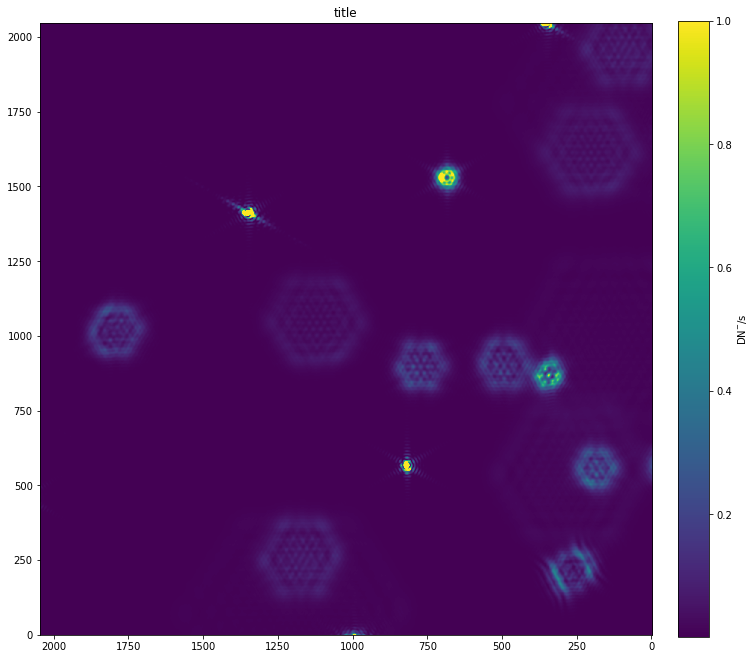

In [163]:
show(cat.seedimage, 'title', min=0.001, max=1e0)

---
# Fifth, combine into a mosaic

In [68]:
# Get list of YAML files for observation 1 (all 10 detectors)
obs1_visit1_files = glob(os.path.join(yaml_dir, 'jw01134001*yaml'))
print('{} yaml files found in program APT 1134 Observation 1'.format(len(obs1_visit1_files)))

60 yaml files found in program APT 1134 Observation 1


In [ ]:
# Generate "mosaic" from images
obs1_fits_files = glob(os.path.join(ote_dir, 'jw*linear.fits'))

with fits.open(obs1_fits_files[0]) as hdu:
    hdu.info()

for f in sorted(obs1_fits_files):
    print(f.split('/')[-1])
    with fits.open(f) as hdu:
        print(hdu[0].header['TARG_RA'])
        print(hdu[0].header['RA_V1'])
        print(hdu[0].header['XOFFSET'], hdu[0].header['YOFFSET'])
        print()